# Dispersion Curves Visualization

This notebook visualizes dispersion curves from daily velocity data files.
It shows individual daily curves and computes median with percentiles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from scipy import stats

In [2]:
# Configuration
data_dir = Path('./output/velocity_data')
percentiles = [5, 25, 75, 95]  # Percentiles to compute
figsize = (12, 8)

In [21]:
# Load all CSV files
csv_files = sorted(data_dir.glob('gring_velocity_2023-01-20.csv'))
print(f"Found {len(csv_files)} daily data files")

# Load all data
all_data = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        df['date'] = pd.to_datetime(df['day'])
        all_data.append(df)
    except Exception as e:
        print(f"Error loading {csv_file.name}: {e}")

if not all_data:
    raise ValueError("No data files found or loaded successfully")

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"Total data points: {len(combined_df)}")
print(f"Date range: {combined_df['date'].min().date()} to {combined_df['date'].max().date()}")
print(f"Frequency bands: {sorted(combined_df['fband'].unique())}")

Found 1 daily data files
Total data points: 107
Date range: 2023-01-20 to 2023-01-20
Frequency bands: [0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398]


In [ ]:
# Group by frequency band and compute statistics
freq_stats = []

for fband in sorted(combined_df['fband'].unique()):
    freq_data = combined_df[combined_df['fband'] == fband]
    
    # Get velocity data (drop NaN)
    velocities = freq_data['velocity'].dropna()
    
    if len(velocities) > 0:
        stats_dict = {
            'fband': fband,
            'median': np.median(velocities),
            'mean': np.mean(velocities),
            'std': np.std(velocities),
            'count': len(velocities)
        }
        
        # Add percentiles
        for p in percentiles:
            stats_dict[f'p{p}'] = np.percentile(velocities, p)
        
        # Weighted average by n_measurements
        if 'n_measurements' in freq_data.columns:
            # Get matching indices for velocities and weights (both must be valid)
            valid_mask = ~freq_data['velocity'].isna() & ~freq_data['n_measurements'].isna()
            velocities_nmeas = freq_data.loc[valid_mask, 'velocity'].values
            weights_nmeas = freq_data.loc[valid_mask, 'n_measurements'].values
            
            # Only compute if we have valid weights
            if len(weights_nmeas) > 0 and np.any(weights_nmeas > 0):
                weights_nmeas = weights_nmeas.astype(float)
                # Normalize weights
                weights_nmeas = weights_nmeas / weights_nmeas.sum()
                weighted_mean_nmeas = np.average(velocities_nmeas, weights=weights_nmeas)
                stats_dict['weighted_mean_nmeas'] = weighted_mean_nmeas
            else:
                stats_dict['weighted_mean_nmeas'] = np.nan
        else:
            stats_dict['weighted_mean_nmeas'] = np.nan
        
        # Weighted average by deviation (using 1/deviation as weight, so lower deviation = higher weight)
        if 'deviation' in freq_data.columns:
            # Get matching indices for velocities and weights
            valid_mask = ~freq_data['velocity'].isna() & ~freq_data['deviation'].isna()
            deviations = freq_data.loc[valid_mask, 'deviation'].values
            velocities_for_dev = freq_data.loc[valid_mask, 'velocity'].values
            
            # Only compute if we have valid deviations
            if len(deviations) > 0 and np.all(deviations > 0):
                # Use 1/deviation as weight (lower deviation = higher weight)
                weights_dev = 1.0 / deviations.astype(float)
                # Normalize weights
                weights_dev = weights_dev / weights_dev.sum()
                weighted_mean_dev = np.average(velocities_for_dev, weights=weights_dev)
                stats_dict['weighted_mean_dev'] = weighted_mean_dev
            else:
                stats_dict['weighted_mean_dev'] = np.nan
        else:
            stats_dict['weighted_mean_dev'] = np.nan
        
        freq_stats.append(stats_dict)

stats_df = pd.DataFrame(freq_stats)
print(f"Statistics computed for {len(stats_df)} frequency bands")
print(f"Columns: {list(stats_df.columns)}")

Statistics computed for 7 frequency bands


In [25]:
all_data[0]

,timestamp,day,fband,velocity,deviation,n_measurements,date
0,2023-01-20 00:30:00,2023-01-20,0.158,4600,3557,16,2023-01-20
1,2023-01-20 00:30:00,2023-01-20,0.200,5100,8646,59,2023-01-20
2,2023-01-20 00:30:00,2023-01-20,0.251,5900,12220,75,2023-01-20
3,2023-01-20 00:30:00,2023-01-20,0.316,3800,91022,112,2023-01-20
4,2023-01-20 00:30:00,2023-01-20,0.398,0,256358,7,2023-01-20
...,...,...,...,...,...,...,...
102,2023-01-20 22:30:00,2023-01-20,0.316,0,7309,14,2023-01-20
103,2023-01-20 23:30:00,2023-01-20,0.158,0,3868,6,2023-01-20
104,2023-01-20 23:30:00,2023-01-20,0.200,700,4313,57,2023-01-20
105,2023-01-20 23:30:00,2023-01-20,0.251,1900,3441,17,2023-01-20


## Plot 1: Individual Daily Dispersion Curves

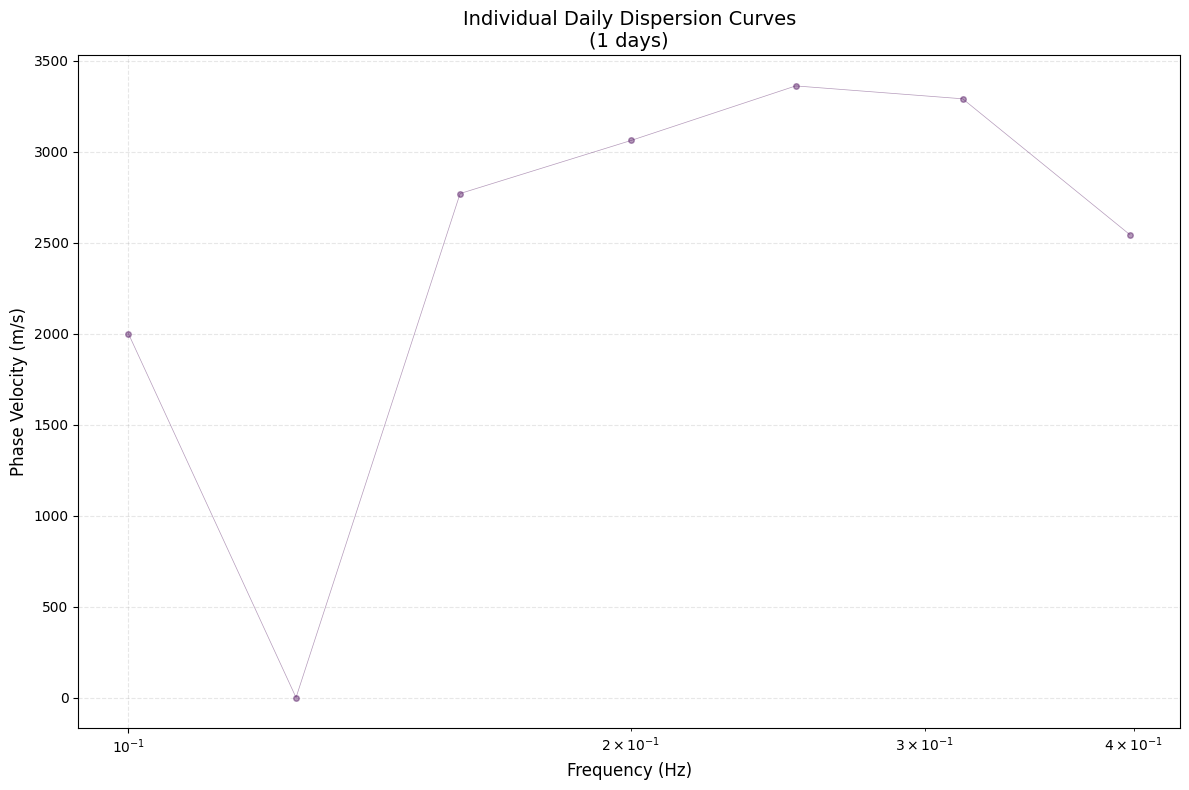

In [24]:
# Plot individual daily curves
fig, ax = plt.subplots(figsize=figsize)

# Get unique dates
unique_dates = sorted(combined_df['date'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_dates)))

for idx, date in enumerate(unique_dates):
    daily_data = combined_df[combined_df['date'] == date]
    
    # Group by frequency band and take mean velocity for each band
    daily_freq = daily_data.groupby('fband')['velocity'].mean().reset_index()
    daily_freq = daily_freq.sort_values('fband')
    
    # Plot as dots connected by lines
    ax.plot(daily_freq['fband'], daily_freq['velocity'], 
            'o-', alpha=0.4, markersize=4, linewidth=0.5, 
            color=colors[idx], label=None)

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Phase Velocity (m/s)', fontsize=12)
ax.set_title(f'Individual Daily Dispersion Curves\n({len(unique_dates)} days)', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Plot 2: Median with Percentile Area

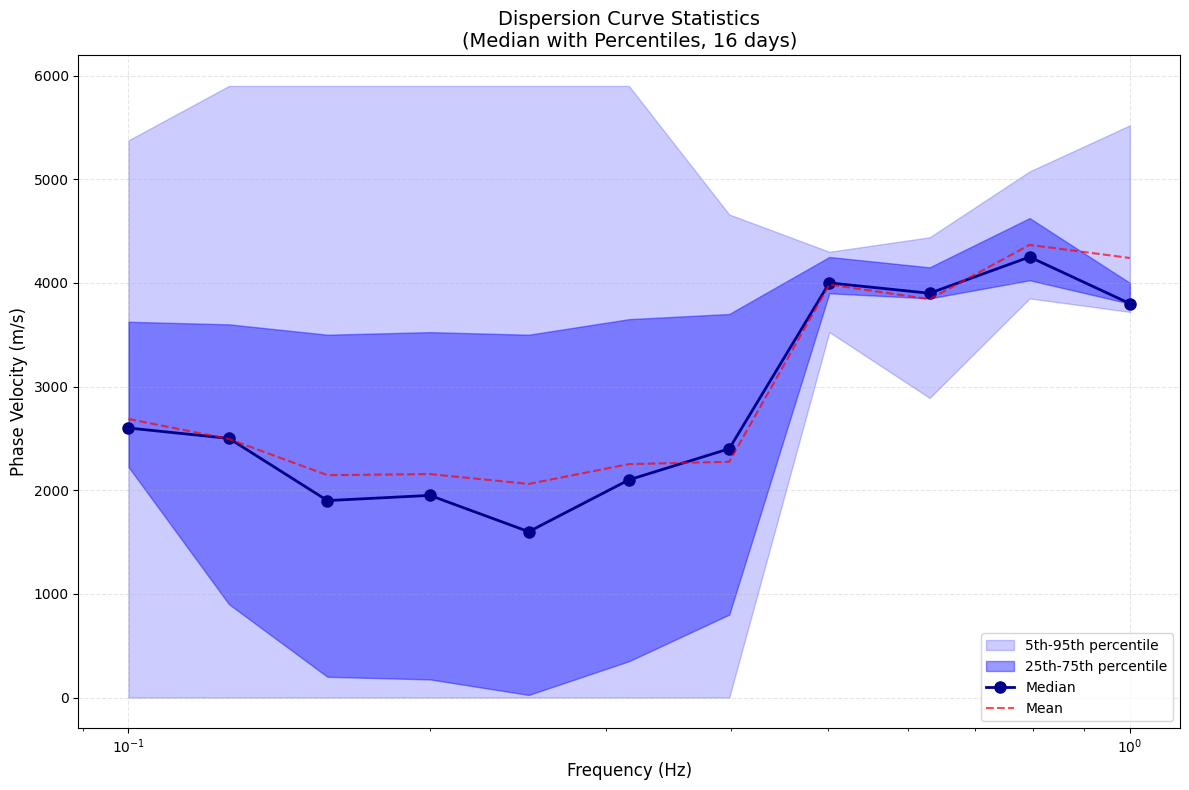

In [ ]:
# Plot median with percentile area
fig, ax = plt.subplots(figsize=figsize)

# Sort by frequency
stats_df_sorted = stats_df.sort_values('fband')

# Get number of unique days for title
num_days = len(combined_df['date'].unique())

freqs = stats_df_sorted['fband'].values
median = stats_df_sorted['median'].values
p5 = stats_df_sorted['p5'].values
p25 = stats_df_sorted['p25'].values
p75 = stats_df_sorted['p75'].values
p95 = stats_df_sorted['p95'].values

# Fill between percentiles
ax.fill_between(freqs, p5, p95, alpha=0.2, color='blue', label='5th-95th percentile')
ax.fill_between(freqs, p25, p75, alpha=0.4, color='blue', label='25th-75th percentile')

# Plot median line
ax.plot(freqs, median, 'o-', color='darkblue', linewidth=2, markersize=8, label='Median')

# Optional: plot mean as dashed line
mean = stats_df_sorted['mean'].values
ax.plot(freqs, mean, '--', color='red', linewidth=1.5, alpha=0.7, label='Mean')

# Plot weighted averages if available
if 'weighted_mean_nmeas' in stats_df_sorted.columns:
    weighted_nmeas = stats_df_sorted['weighted_mean_nmeas'].values
    valid_mask = ~np.isnan(weighted_nmeas)
    if np.any(valid_mask):
        ax.plot(freqs[valid_mask], weighted_nmeas[valid_mask], 's-', 
                color='green', linewidth=1.5, markersize=6, alpha=0.8, 
                label='Weighted mean (by n_measurements)')

if 'weighted_mean_dev' in stats_df_sorted.columns:
    weighted_dev = stats_df_sorted['weighted_mean_dev'].values
    valid_mask = ~np.isnan(weighted_dev)
    if np.any(valid_mask):
        ax.plot(freqs[valid_mask], weighted_dev[valid_mask], '^-', 
                color='orange', linewidth=1.5, markersize=6, alpha=0.8, 
                label='Weighted mean (by 1/deviation)')

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Phase Velocity (m/s)', fontsize=12)
ax.set_title(f'Dispersion Curve Statistics\n(Median with Percentiles, {num_days} days)', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10)
ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Summary Statistics

In [ ]:
# Display summary statistics
print("\nSummary Statistics by Frequency Band:")
print("=" * 100)

# Build header
header_cols = ['Frequency (Hz)', 'Count', 'Median', 'Mean', 'Std', 'P5-P95']
if 'weighted_mean_nmeas' in stats_df_sorted.columns:
    header_cols.append('WtMean(nmeas)')
if 'weighted_mean_dev' in stats_df_sorted.columns:
    header_cols.append('WtMean(1/dev)')

header_str = ' '.join([f"{col:<15}" for col in header_cols])
print(header_str)
print("-" * 100)

for _, row in stats_df_sorted.iterrows():
    row_str = f"{row['fband']:<15.3f} {int(row['count']):<15} {row['median']:<15.1f} {row['mean']:<15.1f} "
    row_str += f"{row['std']:<15.1f} {row['p5']:.1f}-{row['p95']:.1f}"
    
    if 'weighted_mean_nmeas' in stats_df_sorted.columns:
        val = row['weighted_mean_nmeas']
        row_str += f" {val:<15.1f}" if not np.isnan(val) else f" {'NaN':<15}"
    
    if 'weighted_mean_dev' in stats_df_sorted.columns:
        val = row['weighted_mean_dev']
        row_str += f" {val:<15.1f}" if not np.isnan(val) else f" {'NaN':<15}"
    
    print(row_str)


Summary Statistics by Frequency Band:
Frequency (Hz)  Count    Median     Mean       Std        P5-P95         
--------------------------------------------------------------------------------
0.100           200      1700.0     2009.0     1744.1     0.0-5305.0
0.126           810      1950.0     2330.6     2068.9     0.0-5900.0
0.158           1183     2300.0     2566.8     2164.6     0.0-5900.0
0.200           1365     2100.0     2490.1     2141.7     0.0-5900.0
0.251           1371     2200.0     2483.8     2130.8     0.0-5900.0
0.316           1065     2200.0     2414.6     2012.6     0.0-5900.0
0.398           154      1800.0     2146.8     1871.8     0.0-5900.0
0.501           14       3450.0     3150.0     1431.7     890.0-4990.0
0.631           12       3600.0     3266.7     1292.5     1155.0-4910.0
0.794           13       3700.0     3884.6     1292.5     1820.0-5900.0
1.000           12       3600.0     3400.0     680.7      2240.0-4180.0
